In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Original data

In [2]:
# 500 GeV: 取 50000 + 50000
data_s = np.load('./Sample/DNN/min_dR_high_level_500GeV_train.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_train.npy', allow_pickle=True).item()

n = 50000
data_s = data_s['data'][data_s['label'] == 1][:n]
data_b = data_b['data'][data_b['label'] == 0][:n]

data_dict = {
    'data': np.vstack([data_s, data_b]),
    'label': np.array([1] * data_s.shape[0] + [0] * data_b.shape[0]),
}

np.save('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', data_dict)

In [3]:
# 500 GeV: 取 5000 + 5000
data_s = np.load('./Sample/DNN/min_dR_high_level_500GeV_test.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_test.npy', allow_pickle=True).item()

n = 5000 
data_s = data_s['data'][data_s['label'] == 1][:n]
data_b = data_b['data'][data_b['label'] == 0][:n]

data_dict = {
    'data': np.vstack([data_s, data_b]),
    'label': np.array([1] * data_s.shape[0] + [0] * data_b.shape[0]),
}

np.save('./Sample/DNN/physical_augmentation/min_dR_500GeV_test.npy', data_dict)

# Data augmentation

In [4]:
def std_phi(phi):
    # return the phi in range [-pi, pi]
    while np.any(phi > np.pi):
        phi[phi > np.pi] -= 2 * np.pi
    while np.any(phi < -np.pi):
        phi[phi < -np.pi] += 2 * np.pi
    return phi

## Rotation

In [5]:
# Rotation augmentation: The final state is rotated by the angle phi randomly choose from [0, 2pi]
def rotation_augmentation(origin_file, output_path, n=5):
    _data = np.load(origin_file, allow_pickle=True).item()
    data, label = _data['data'], _data['label']

    # The phi of the first and second jet
    phi_1_2 = data[:,[2,6]]

    data_aug = [data]
    label_aug = [label]

    for i in range(n):
        # Randomly choose the rotation angle phi from [0, 2pi]
        dPhi = np.random.uniform(0, 2*np.pi, data.shape[0])
        rot_phi_1_2 = std_phi(phi_1_2 + dPhi[:,None])
        data[:,[2,6]] = rot_phi_1_2

        data_aug.append(data)
        label_aug.append(label)

    data_aug = np.vstack(data_aug)
    label_aug = np.hstack(label_aug)

    data_dict = {
        'data': data_aug,
        'label': label_aug,
    }

    np.save(output_path, data_dict)
    print(f'Save to {output_path}')


In [6]:
origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_rot_3.npy'
rotation_augmentation(origin_file, output_path, n=3)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_rot_5.npy'
rotation_augmentation(origin_file, output_path, n=5)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_rot_10.npy'
rotation_augmentation(origin_file, output_path, n=10)

Save to ./Sample/DNN/physical_augmentation/min_dR_500GeV_rot_3.npy
Save to ./Sample/DNN/physical_augmentation/min_dR_500GeV_rot_5.npy
Save to ./Sample/DNN/physical_augmentation/min_dR_500GeV_rot_10.npy


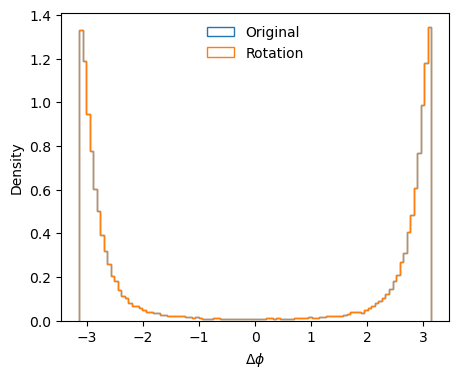

In [7]:
# Plot phi distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['data']

phi_1_2 = data[:,[2,6]]
dPhi = phi_1_2[:,1] - phi_1_2[:,0]
dPhi = std_phi(dPhi)
ax.hist(dPhi, bins=100, histtype='step', label='Original', density=True)

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_rot_5.npy', allow_pickle=True).item()['data']

phi_1_2 = data[:,[2,6]]
dPhi = phi_1_2[:,1] - phi_1_2[:,0]
dPhi = std_phi(dPhi)

ax.hist(dPhi, bins=100, histtype='step', label='Rotation', density=True)
ax.legend(frameon=False, loc='upper center')
ax.set_xlabel('$\Delta\phi$')
ax.set_ylabel('Density')
plt.show()


## $\eta - \phi$ smearing

In [8]:
def eta_phi_smearing(origin_file, output_path, n=5):

    _data = np.load(origin_file, allow_pickle=True).item()
    data, label = _data['data'], _data['label']

    # The pt, eta, phi of the first and second jet
    pt1, pt2 = data[:,0], data[:,4]
    eta1, eta2 = data[:,1], data[:,5]
    phi1, phi2 = data[:,2], data[:,6]

    std_scale = 10

    data_aug = [data]
    label_aug = [label]

    for i in range(n):
        data_tmp = np.copy(data)
        # Smearing the eta and phi of the first and second jet
        data_tmp[:,1] = np.random.normal(loc=eta1, scale=std_scale/pt1)
        data_tmp[:,5] = np.random.normal(loc=eta2, scale=std_scale/pt2)
        data_tmp[:,2] = std_phi(np.random.normal(loc=phi1, scale=std_scale/pt1))
        data_tmp[:,6] = std_phi(np.random.normal(loc=phi2, scale=std_scale/pt2))

        data_aug.append(data_tmp)
        label_aug.append(label)

    data_aug = np.vstack(data_aug)
    label_aug = np.hstack(label_aug)

    data_dict = {
        'data': data_aug,
        'label': label_aug,
    }

    np.save(output_path, data_dict)

In [9]:
origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_3.npy'
eta_phi_smearing(origin_file, output_path, n=3)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy'
eta_phi_smearing(origin_file, output_path, n=5)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_10.npy'
eta_phi_smearing(origin_file, output_path, n=10)

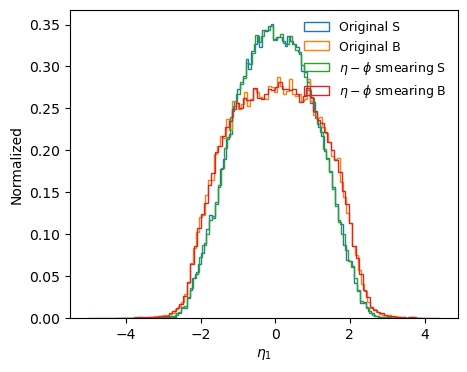

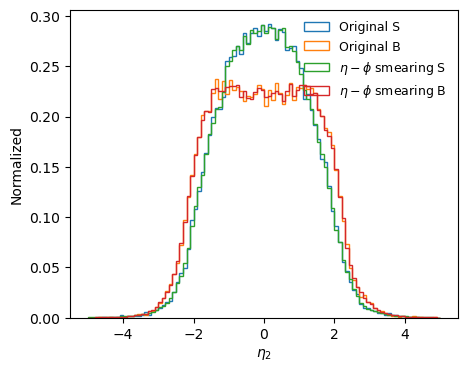

In [10]:
# plot the distribution of eta

fig, ax = plt.subplots(1,1, figsize=(5,4))

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['label']
eta1 = data[:,1]
ax.hist(eta1[label==1], bins=100, histtype='step', label='Original S', density=True)
ax.hist(eta1[label==0], bins=100, histtype='step', label='Original B', density=True)

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['label']
eta1 = data[:,1]
ax.hist(eta1[label==1], bins=100, histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(eta1[label==0], bins=100, histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.set_xlabel('$\eta_1$')
ax.set_ylabel('Normalized')

ax.legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig('./figures/eta1_distribution_eta_phi_smearing.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['label']
eta2 = data[:,5]
ax.hist(eta2[label==1], bins=100, range=(-5,5), histtype='step', label='Original S', density=True)
ax.hist(eta2[label==0], bins=100, range=(-5,5), histtype='step', label='Original B', density=True)


data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['label']
eta2 = data[:,5]
ax.hist(eta2[label==1], bins=100, range=(-5,5), histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(eta2[label==0], bins=100, range=(-5,5), histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.set_xlabel('$\eta_2$')
ax.set_ylabel('Normalized')

ax.legend(frameon=False, loc='upper right', fontsize=9)

plt.savefig('./figures/eta2_distribution_eta_phi_smearing.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

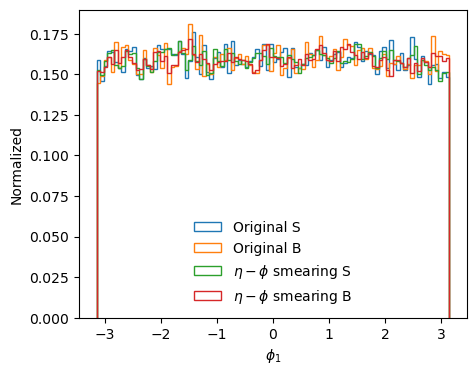

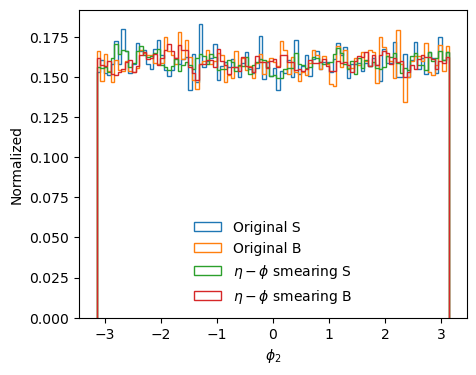

In [11]:
# plot the distribution of phi
fig, ax = plt.subplots(1,1, figsize=(5,4))

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['label']
phi1 = data[:,2]
ax.hist(phi1[label==1], bins=100, histtype='step', label='Original S', density=True)
ax.hist(phi1[label==0], bins=100, histtype='step', label='Original B', density=True)


data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['label']
phi1 = data[:,2]
ax.hist(phi1[label==1], bins=100, histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(phi1[label==0], bins=100, histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.set_xlabel('$\phi_1$')
ax.set_ylabel('Normalized')

ax.legend(frameon=False, loc='lower center')
plt.savefig('./figures/phi1_distribution_eta_phi_smearing.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['label']
phi2 = data[:,6]
ax.hist(phi2[label==1], bins=100, histtype='step', label='Original S', density=True)
ax.hist(phi2[label==0], bins=100, histtype='step', label='Original B', density=True)


data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_5.npy', allow_pickle=True).item()['label']
phi2 = data[:,6]
ax.hist(phi2[label==1], bins=100, histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(phi2[label==0], bins=100, histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.set_xlabel('$\phi_2$')
ax.set_ylabel('Normalized')

ax.legend(frameon=False, loc='lower center')
plt.savefig('./figures/phi2_distribution_eta_phi_smearing.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## $p_{\mathrm{T}}$ smearing

In [12]:
def pt_scale(pt):
    return np.sqrt(0.052*pt*pt + 1.502*pt)

def pt_smearing(origin_file, output_path, n=5):

    _data = np.load(origin_file, allow_pickle=True).item()
    data, label = _data['data'], _data['label']

    # The pt of the first and second jet
    pt1, pt2 = data[:,0], data[:,4]

    data_aug = [data]
    label_aug = [label]

    for i in range(n):
        data_tmp = np.copy(data)
        # Smearing the pt of the first and second jet
        data_tmp[:,0] = np.random.normal(loc=pt1, scale=pt_scale(pt1))
        data_tmp[:,4] = np.random.normal(loc=pt2, scale=pt_scale(pt2))

        data_aug.append(data_tmp)
        label_aug.append(label)

    data_aug = np.vstack(data_aug)
    label_aug = np.hstack(label_aug)

    data_dict = {
        'data': data_aug,
        'label': label_aug,
    }

    np.save(output_path, data_dict)

In [13]:
origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_3.npy'
pt_smearing(origin_file, output_path, n=3)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_5.npy'
pt_smearing(origin_file, output_path, n=5)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_10.npy'
pt_smearing(origin_file, output_path, n=10)

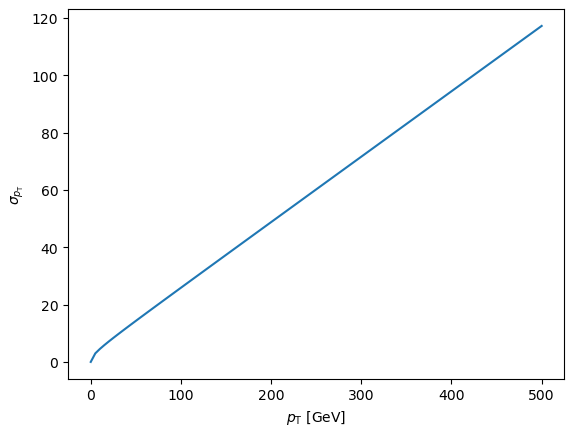

In [14]:
# plot pt_scale function
pt = np.linspace(0, 500, 100)
plt.plot(pt, pt_scale(pt))
plt.xlabel('$p_\mathrm{T}$ [GeV]')
plt.ylabel('$\sigma_{p_\mathrm{T}}$')
plt.show()

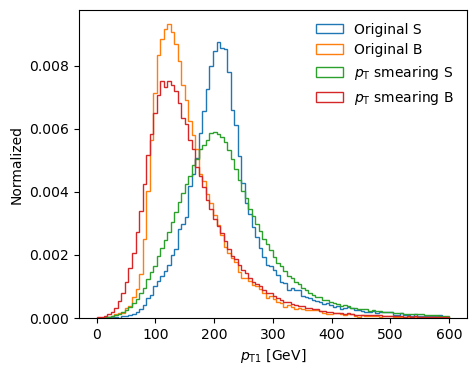

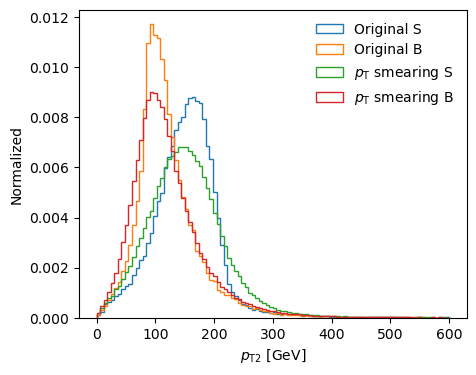

In [15]:
# plot the distribution of the first Higgs's pt
fig, ax = plt.subplots(1,1, figsize=(5,4))

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['label']
ax.hist(data[:,0][label==1], bins=100, range=(0, 600), histtype='step', label='Original S', density=True)
ax.hist(data[:,0][label==0], bins=100, range=(0, 600), histtype='step', label='Original B', density=True)

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_5.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_5.npy', allow_pickle=True).item()['label']
# ax.hist(data[:,0], bins=100, range=(0, 600), histtype='step', label='$p_\mathrm{T}$ smearing', density=True)
ax.hist(data[:,0][label==1], bins=100, range=(0, 600), histtype='step', label='$p_\mathrm{T}$ smearing S', density=True)
ax.hist(data[:,0][label==0], bins=100, range=(0, 600), histtype='step', label='$p_\mathrm{T}$ smearing B', density=True)

ax.legend()
ax.set_xlabel('$p_\mathrm{T1}$ [GeV]')
ax.set_ylabel('Normalized')
ax.legend(frameon=False)

plt.savefig('./figures/pt1_distribution_pt_smearing.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# plot the distribution of the second Higgs's pt
fig, ax = plt.subplots(1,1, figsize=(5,4))

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy', allow_pickle=True).item()['label']
ax.hist(data[:,4][label==1], bins=100, range=(0, 600), histtype='step', label='Original S', density=True)
ax.hist(data[:,4][label==0], bins=100, range=(0, 600), histtype='step', label='Original B', density=True)

data = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_5.npy', allow_pickle=True).item()['data']
label = np.load('./Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_5.npy', allow_pickle=True).item()['label']
ax.hist(data[:,4][label==1], bins=100, range=(0, 600), histtype='step', label='$p_\mathrm{T}$ smearing S', density=True)
ax.hist(data[:,4][label==0], bins=100, range=(0, 600), histtype='step', label='$p_\mathrm{T}$ smearing B', density=True)

ax.legend()
ax.set_xlabel('$p_\mathrm{T2}$ [GeV]')
ax.set_ylabel('Normalized')
ax.legend(frameon=False)

plt.savefig('./figures/pt2_distribution_pt_smearing.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()


## Simultaneous augmentation

In [16]:
# Combine all the augmentation
def combine_augmentation(origin_file, output_path, n=5):
    _data = np.load(origin_file, allow_pickle=True).item()
    data, label = _data['data'], _data['label']

    # The pt, eta, phi of the first and second Higgs candidates
    pt1, pt2 = data[:,0], data[:,4]
    eta1, eta2 = data[:,1], data[:,5]
    phi1, phi2 = data[:,2], data[:,6]

    std_scale = 10

    data_aug = [data]
    label_aug = [label]

    for i in range(n):
        data_tmp = np.copy(data)
        # Smearing the eta, phi and pt of Higgs candidates
        data_tmp[:,1] = np.random.normal(loc=eta1, scale=std_scale/pt1)
        data_tmp[:,5] = np.random.normal(loc=eta2, scale=std_scale/pt2)
        data_tmp[:,2] = std_phi(np.random.normal(loc=phi1, scale=std_scale/pt1))
        data_tmp[:,6] = std_phi(np.random.normal(loc=phi2, scale=std_scale/pt2))
        data_tmp[:,0] = np.random.normal(loc=pt1, scale=pt_scale(pt1))
        data_tmp[:,4] = np.random.normal(loc=pt2, scale=pt_scale(pt2))

        # Randomly choose the rotation angle phi from [0, 2pi]
        phi_1_2 = data_tmp[:,[2,6]]
        dPhi = np.random.uniform(0, 2*np.pi, data.shape[0])
        rot_phi_1_2 = std_phi(phi_1_2 + dPhi[:,None])
        data_tmp[:,[2,6]] = rot_phi_1_2

        data_aug.append(data_tmp)
        label_aug.append(label)

    data_aug = np.vstack(data_aug)
    label_aug = np.hstack(label_aug)

    data_dict = {
        'data': data_aug,
        'label': label_aug,
    }

    np.save(output_path, data_dict)

In [17]:
origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_all_aug_3.npy'
combine_augmentation(origin_file, output_path, n=3)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_all_aug_5.npy'
combine_augmentation(origin_file, output_path, n=5)

origin_file = './Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
output_path = './Sample/DNN/physical_augmentation/min_dR_500GeV_all_aug_10.npy'
combine_augmentation(origin_file, output_path, n=10)

# Training

In [18]:
train_file = '../Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy'
model_name = '500GeV_origind'
sample_type = '"500GeV: Origin"'
cmd = f'python train_DNN_physical_augmentation.py {train_file} {model_name} {sample_type}'
print(cmd)

python train_DNN_physical_augmentation.py ../Sample/DNN/physical_augmentation/min_dR_500GeV_origin.npy 500GeV_origind "500GeV: Origin"


In [19]:
train_file = '../Sample/DNN/physical_augmentation/min_dR_500GeV_rot_3.npy'
model_name = '500GeV_rot_3'
sample_type = '"500GeV: Rotation 3"'
cmd = f'python train_DNN_physical_augmentation.py {train_file} {model_name} {sample_type}'
print(cmd)

python train_DNN_physical_augmentation.py ../Sample/DNN/physical_augmentation/min_dR_500GeV_rot_3.npy 500GeV_rot_3 "500GeV: Rotation 3"


In [20]:
train_file = '../Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_3.npy'
model_name = '500GeV_EtaPhi_smear_3'
sample_type = '"500GeV: Eta Phi smearing 3"'
cmd = f'python train_DNN_physical_augmentation.py {train_file} {model_name} {sample_type}'
print(cmd)

python train_DNN_physical_augmentation.py ../Sample/DNN/physical_augmentation/min_dR_500GeV_EtaPhi_smear_3.npy 500GeV_EtaPhi_smear_3 "500GeV: Eta Phi smearing 3"


In [21]:
train_file = '../Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_3.npy'
model_name = '500GeV_pT_smear_3'
sample_type = '"500GeV: pT smearing 3"'
cmd = f'python train_DNN_physical_augmentation0.py {train_file} {model_name} {sample_type}'
print(cmd)

python train_DNN_physical_augmentation0.py ../Sample/DNN/physical_augmentation/min_dR_500GeV_pT_smear_3.npy 500GeV_pT_smear_3 "500GeV: pT smearing 3"


In [22]:
train_file = '../Sample/DNN/physical_augmentation/min_dR_500GeV_all_aug_3.npy'
model_name = '500GeV_all_aug_3'
sample_type = '"500GeV: All augmentation 3"'
cmd = f'python train_DNN_physical_augmentation0.py {train_file} {model_name} {sample_type}'
print(cmd)

python train_DNN_physical_augmentation0.py ../Sample/DNN/physical_augmentation/min_dR_500GeV_all_aug_3.npy 500GeV_all_aug_3 "500GeV: All augmentation 3"


# Results

In [23]:
file_name = './DNN/DNN_physical_augmentation_results.csv'
df = pd.read_csv(file_name)

In [35]:
def print_results(df, sample_type):
    mu = df[df['Sample Type'] == sample_type]['ACC'].mean()
    sigma = df[df['Sample Type'] == sample_type]['ACC'].std()
    best = df[df['Sample Type'] == sample_type]['ACC'].max()
    print(f'ACC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')
    # print(f'${mu:.3f}\pm{sigma:.3f}$')

    mu = df[df['Sample Type'] == sample_type]['AUC'].mean()
    sigma = df[df['Sample Type'] == sample_type]['AUC'].std()
    best = df[df['Sample Type'] == sample_type]['AUC'].max()
    print(f'AUC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')
    # print(f'${mu:.3f}\pm{sigma:.3f}$')

In [36]:
print('Original sample')
print_results(df, '500GeV: Origin')

Original sample
ACC: 0.845 +- 0.015, Best: 0.859
AUC: 0.917 +- 0.005, Best: 0.923


In [37]:
print('Rotation augmentation')
print_results(df, '500GeV: Rotation 3')
print_results(df, '500GeV: Rotation 5')
print_results(df, '500GeV: Rotation 10')

Rotation augmentation
ACC: 0.880 +- 0.007, Best: 0.889
AUC: 0.950 +- 0.007, Best: 0.956
ACC: 0.887 +- 0.002, Best: 0.889
AUC: 0.955 +- 0.001, Best: 0.956
ACC: 0.889 +- 0.001, Best: 0.891
AUC: 0.956 +- 0.001, Best: 0.957


In [38]:
print('Eta Phi smearing')
print_results(df, '500GeV: Eta Phi smearing 3')
print_results(df, '500GeV: Eta Phi smearing 5')
print_results(df, '500GeV: Eta Phi smearing 10')

Eta Phi smearing
ACC: 0.879 +- 0.010, Best: 0.888
AUC: 0.949 +- 0.008, Best: 0.955
ACC: 0.887 +- 0.001, Best: 0.889
AUC: 0.955 +- 0.001, Best: 0.956
ACC: 0.889 +- 0.002, Best: 0.891
AUC: 0.956 +- 0.001, Best: 0.957


In [39]:
print('pT smearing')
print_results(df, '500GeV: pT smearing 3')
print_results(df, '500GeV: pT smearing 5')
print_results(df, '500GeV: pT smearing 10')

pT smearing
ACC: 0.882 +- 0.003, Best: 0.888
AUC: 0.951 +- 0.003, Best: 0.955
ACC: 0.890 +- 0.002, Best: 0.892
AUC: 0.957 +- 0.001, Best: 0.957
ACC: 0.892 +- 0.002, Best: 0.895
AUC: 0.958 +- 0.001, Best: 0.959


In [40]:
print('All augmentation')
print_results(df, '500GeV: All augmentation 3')
print_results(df, '500GeV: All augmentation 5')
print_results(df, '500GeV: All augmentation 10')

All augmentation
ACC: 0.875 +- 0.011, Best: 0.886
AUC: 0.942 +- 0.012, Best: 0.954
ACC: 0.889 +- 0.003, Best: 0.892
AUC: 0.956 +- 0.001, Best: 0.958
ACC: 0.892 +- 0.002, Best: 0.894
AUC: 0.958 +- 0.000, Best: 0.959
